<a href="https://colab.research.google.com/github/Shaam93/Building-a-classifer-with-Pytorch/blob/master/pytorch_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First as usual we import the libraries we need for our classifier
(we just need to unstall torch and pillow)

In [1]:
#Currently the Pytorch version 1.0 is stable and we even have better versions (when I recorded the video only 0.4.0 was stable)
#!pip install torch==0.4.0 torchvision
#!pip install torch torchvision
import torch
print ("current pytorch version is: ", torch.__version__)
# we need pillow version of 5.3.0
#!pip install Pillow==5.3.0
import PIL
print ("current pillow version is: ", PIL.__version__)

current pytorch version is:  1.6.0
current pillow version is:  7.2.0


In [2]:
import time
import json
import copy
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
print ("done importing")


done importing


Setting up the directories to read the data

In [7]:
#data_dir = 'flower_data'
train_dir = 'pet-classifier-images'
valid_dir = 'validation-images'
test_dir= 'unused-images'


dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir
       }

Setting up the image transforms

In [8]:
# add transforms to the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.Resize((224, 224)),#attention 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

Setting up the data loaders

In [9]:
# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
# load the data into batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

Getting the class labels

In [10]:
class_names = image_datasets['train'].classes
print(class_names)

['Choubie', 'Jellie']


Reading the Json file

In [11]:
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'cat_to_name.json'

Showing a batch of images after applying the transforms on them

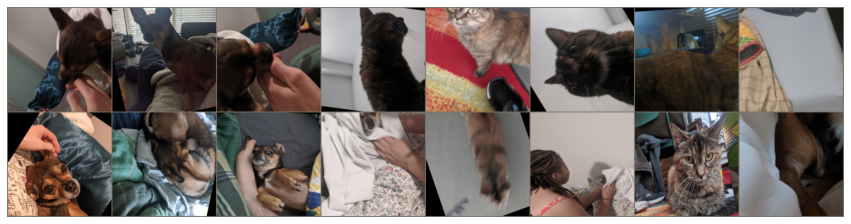

In [13]:
import torchvision
import matplotlib.pyplot as plt
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off') 
        
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

In [20]:
# choose the model
model = models.resnet18(pretrained=True)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
model.fc = nn.Linear(512, 2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
#unfreezing the model parameters

In [23]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:

if torch.cuda.is_available():
  device= torch.device('cuda')
  print("CUDA is avaialble")
else:
  device= torch.device('cpu')
  print("Only CPU")


CUDA is avaialble


Using pre-trained models ...... To be continued!

In [25]:
#training/validating function 
# this part of code is from https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad
#I changed minor things for my convinience
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs ))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [28]:
criteria = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Number of epochs
eps=20

In [29]:
model = train_model(model, criteria, optimizer, scheduler, eps, 'cuda')

Epoch 1/20
----------
train Loss: 0.2148 Acc: 0.9470
valid Loss: 0.4204 Acc: 0.8333

Epoch 2/20
----------
train Loss: 0.1812 Acc: 0.9404
valid Loss: 0.2662 Acc: 0.8333

Epoch 3/20
----------
train Loss: 0.2388 Acc: 0.9073
valid Loss: 0.1932 Acc: 0.8333

Epoch 4/20
----------
train Loss: 0.1624 Acc: 0.9404
valid Loss: 0.3407 Acc: 0.8333

Epoch 5/20
----------
train Loss: 0.1243 Acc: 0.9669
valid Loss: 0.1689 Acc: 0.8333

Epoch 6/20
----------
train Loss: 0.1078 Acc: 0.9669
valid Loss: 0.1131 Acc: 1.0000

Epoch 7/20
----------
train Loss: 0.1166 Acc: 0.9735
valid Loss: 0.1729 Acc: 0.8333

Epoch 8/20
----------
train Loss: 0.0910 Acc: 0.9603
valid Loss: 0.1557 Acc: 0.8333

Epoch 9/20
----------
train Loss: 0.1057 Acc: 0.9735
valid Loss: 0.1593 Acc: 0.8333

Epoch 10/20
----------
train Loss: 0.0985 Acc: 0.9669
valid Loss: 0.1820 Acc: 0.8333

Epoch 11/20
----------
train Loss: 0.1078 Acc: 0.9735
valid Loss: 0.1209 Acc: 1.0000

Epoch 12/20
----------
train Loss: 0.0870 Acc: 0.9735
valid Los